In [1]:
from collections import deque
import random

#Third-Party packages
import osmnx as ox
import networkx as nx

In [2]:
#Uses turns on console and use of cahce
ox.config(use_cache=True, log_console=True)

#Gets graph from bounding box provided, projects it
graph = ox.graph_from_bbox(48.1510, 48.1249, 11.5430, 11.6104, network_type='walk', simplify=True, retain_all=False)

#Projects graph into respective UTM system
graph_projected = ox.project_graph(graph)

# Gets the all the nodes and edges from a graph
nodes, edges = ox.graph_to_gdfs(graph_projected, nodes=True, edges=True)

In [3]:
#Gets a random start and random target nodes to test each time
nodes_list = []
for row in nodes.itertuples(index=True):
    nodes_list.append(row[0]) 

source = random.choice(nodes_list)
target = random.choice(nodes_list)

In [4]:
def function_2q(graph, source, target):
    # Infinity should be at least as big as the edges cumulative distance 
    # Thus, greater than "street_length_total: 545115" found in ox.basic_stats(graph_projected)
    infinity = 99999999

    #Records the shortest distance to give each node, it will be updated as we go
    shortest_distance = {} 

    # All nodes should be set to infinity. Source node to 0.
    for row in nodes.itertuples(index=True):
        shortest_distance[row[0]] = infinity 
    shortest_distance[source] = 0

#--------------------------------------------------------------------------------#

    #Pallottino Implementation

    #Starts the two queues
    queue_labeled = deque([])
    queue_unlabeled = deque([])

    #Starts the queue with "Source" node
    queue_labeled.append(source)

    #Keeps track of the path that has led us to current node
    track_predecessor = {}
    
    #Track visited nodes
    visited = []

    #Starts Queue, running until it is empty.
    while queue_labeled:
    
        #If queue_labeled is empty, it takes the first entry of the queue_unlabeled 
        if len(queue_labeled) == 0:
            queue_labeled.append(queue_unlabeled[0])   
        current_node = queue_labeled.popleft()
    
        #Adds current node to list of visited nodes 
        visited.append(current_node)
    
        #Loops through all neighbors of the current node
        for neighbor in nx.all_neighbors(graph_projected,current_node):
      
            if neighbor not in visited:
                            
                #Condition that checks if neighbor is present in any of the queues
                neighbor_not_in_queue = neighbor not in queue_labeled or neighbor not in queue_unlabeled
                
                #If the neighbor is unlabeled 
                if neighbor_not_in_queue and shortest_distance[neighbor] == infinity:
                    queue_unlabeled.append(neighbor)
                 
                #If the neighbor is temporarily labeled
                if neighbor_not_in_queue and shortest_distance[neighbor] != infinity:
                    queue_labeled.append(neighbor)
                
                
                
                #Gets the path length between current node and neighbor
                path = [current_node, neighbor]
                distance = nx.path_weight(graph_projected, path, "length")
  
                #Updates the shortest distance to neighbor if applicable    
                if shortest_distance[current_node] + distance < shortest_distance[neighbor]:
                    shortest_distance[neighbor] = shortest_distance[current_node] + distance        
                    track_predecessor[neighbor] = current_node
    
    
    #Backtraces the optimal path, by using the computed best predecessor until we reach the start node
    currentNode = target
    track_path = []

    while currentNode != source:
        try:
            track_path.insert(0, currentNode)
            currentNode = track_predecessor[currentNode]

        except KeyError:
            print("Path does not exist!")
            break

    track_path.insert(0, source)

    #For the possibility of there being an unchecked node (thus an error)
    if shortest_distance[target] != infinity:
        return track_path

In [5]:
route = function_2q(graph, source, target)
print(route)

[3680522990, 1689007015, 638954983, 28097502, 607162441, 3680523011, 607162456, 607162458, 607162462, 8764244222, 21263195, 28466156, 27342923, 28466589, 1955068, 27342939, 1072805401, 398764, 270533681, 254086401, 1156765698, 643083220, 248045943, 248045927, 248046670, 424275551, 401735628, 21677822, 9048025539, 9048025538, 21677818, 1610015075, 430234728, 7905893707, 7905893706, 7905893703, 7905893698]


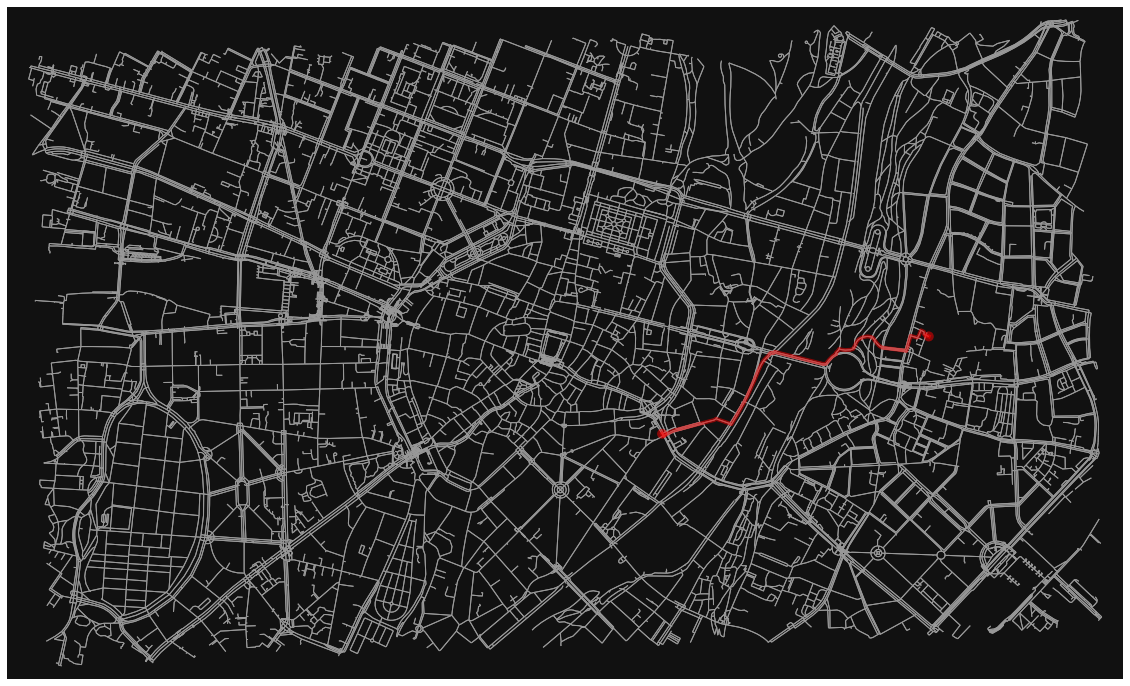

In [6]:
fig, ax = ox.plot_graph_route(graph_projected, route, node_size = 0, figsize=(20, 20), dpi=10000)